In [145]:
import os
import shutil
import random
import logging
import time
from tempfile import TemporaryDirectory
from PIL import Image
from sklearn.metrics import f1_score, confusion_matrix, classification_report, ConfusionMatrixDisplay

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision.transforms import RandAugment

import torchvision
from torchvision import models, transforms

# Configurations
cudnn.benchmark = True
plt.ion()  # interactive mode

# Logging Configuration
logging.basicConfig(
    level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s"
)

# Set random seed for reproducibility
manualSeed = 999
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)
torch.use_deterministic_algorithms(True) # Needed for reproducible results

%set_env CUBLAS_WORKSPACE_CONFIG=:4096:8

Random Seed:  999
env: CUBLAS_WORKSPACE_CONFIG=:4096:8


## Preparing a Balanced Subset of the Dataset

To speed up training while maintaining representativeness, we create a smaller, balanced dataset from our large collection (30K real, 90K fake images). We randomly sample 900 real and 900 fake images, then split them into 80% training and 20% validation sets.

The images are organized into resized_data/ for easy use with PyTorch’s ImageFolder:
```
resized_data/
├── train/
│   ├── real/   # 720 images
│   ├── fake/   # 720 images
├── val/
│   ├── real/   # 180 images
│   ├── fake/   # 180 images
```

In [147]:
# Base data path
BASE_DATA_DIR = "data"
RESIZED_DATA_DIR = "resized_data"

# Directories for real and fake images
REAL_DIR = os.path.join(BASE_DATA_DIR, "wiki")  # Path to real images
FAKE_DIRS = ["inpainting", "insight", "text2img"]  # Directories for fake images

TRAIN_SPLIT = 0.7
VAL_SPLIT = 0.15
TEST_SPLIT = 0.15
assert(TRAIN_SPLIT + VAL_SPLIT + TEST_SPLIT == 1)

# Number of desired images
num_real_images = 30000
num_fake_images_per_folder = 30000

def create_directories():
    """Creates necessary directories for train and validation sets, removing old data first."""
    for category in ['train', 'val', 'test']:
        for subdir in ['real', 'fake']:
            dir_path = os.path.join(RESIZED_DATA_DIR, category, subdir)

            # Remove all existing files to prevent dataset accumulation
            if os.path.exists(dir_path):
                shutil.rmtree(dir_path)

            os.makedirs(dir_path, exist_ok=False)

def get_image_paths(directory):
    """Returns a list of image file paths within a directory structure."""
    image_paths = []
    for subdir in os.listdir(directory):
        subdir_path = os.path.join(directory, subdir)
        if os.path.isdir(subdir_path):
            image_paths.extend(
                [
                    os.path.join(subdir_path, file)
                    for file in os.listdir(subdir_path)
                    if os.path.isfile(os.path.join(subdir_path, file))
                ]
            )
    return image_paths

def split_and_copy_images(image_paths, category):
    """Splits images into training, validation and test sets and copies them accordingly."""
    train, val, test = random_split(image_paths, [TRAIN_SPLIT, VAL_SPLIT, TEST_SPLIT])
    def save_images(image_paths, destination):
        for image_path in image_paths:
            # Turns out images can have the same name, so we add a timestamp to the filename
            target_path = os.path.join(RESIZED_DATA_DIR, destination, category, str(time.time()) + os.path.basename(image_path))
            shutil.copy(image_path, target_path)
    save_images(train, 'train')
    save_images(val, 'val')
    save_images(test, 'test')

# Function to split images into 'train' and 'val'
def organize_data():
    # Create destination directories
    create_directories()

    # Handle real images
    real_images = get_image_paths(REAL_DIR)
    # Random sampling of real images
    sampled_real_images = random.sample(real_images, num_real_images)
    logging.info(f"Sampled {len(sampled_real_images)} real images.")

    # Split into train, val, test and copy to destination
    split_and_copy_images(sampled_real_images, 'real')

    # Handle fake images and random sampling
    sampled_fake_images = {
        fake_dir: random.sample(
            get_image_paths(os.path.join(BASE_DATA_DIR, fake_dir)),
            num_fake_images_per_folder,
        )
        for fake_dir in FAKE_DIRS
    }

    total_sampled_fake_images = sum(len(imgs) for imgs in sampled_fake_images.values())
    logging.info(f"Sampled {total_sampled_fake_images} fake images.")

    # Split into train, val, test and copy to destination
    for dir, sampled_images in sampled_fake_images.items():
        split_and_copy_images(sampled_images, 'fake')

    logging.info("Data organized successfully.")

organize_data()

2025-03-18 18:35:56,296 - INFO - Sampled 30000 real images.
2025-03-18 18:35:57,720 - INFO - Sampled 90000 fake images.
2025-03-18 18:36:00,747 - INFO - Data organized successfully.


## Loading and Preprocessing the Dataset

We now load the resized dataset and apply appropriate transformations for training and validation:

- **Training data**: Includes random cropping and horizontal flipping for augmentation, helping the model generalize better.
- **Validation data**: Only resized and centered to maintain consistency.
- **Normalization**: Standardizes pixel values using ImageNet’s mean and standard deviation.

## Transforms
Different model architectures require different transforms. For example, the image size to feed to a network may vary depending on the architecture.

### Augmentation
Some architectures may benefit more from certain data augmentation techniques than others, so we need to choose data augmentation methods carefully for each architecture.

In [148]:
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

In [149]:
# Data augmentation and normalization for training
# Just normalization for validation

# Also accessible with models.ResNet18_Weights.transforms()
resnet_basic_transform = transforms.Compose(
    [
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
    ]
)
resnet_augmentation_transform = transforms.Compose(
    [
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(p=0.5),  # Randomly flip horizontally
        transforms.RandomRotation(degrees=15),  # Rotate up to 15 degrees
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Random color changes
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
    ]
)

efficient_net_basic_transform = transforms.Compose([
    transforms.Resize(384),
    transforms.CenterCrop(384),
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
])
efficient_net_augmentation_transform = transforms.Compose([
    transforms.RandomResizedCrop(384),
    transforms.RandomHorizontalFlip(p=0.5),
    RandAugment(),  # applies some transforms (randomly chosen)
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
])

vit_basic_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
])
vit_augmentation_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
])

models_tranforms_dict = {
    "resnet": {
        "train": resnet_augmentation_transform,
        "val": resnet_basic_transform,
        "test": resnet_basic_transform,
    },
    "efficient_net": {
        "train": efficient_net_augmentation_transform,
        "val": efficient_net_basic_transform,
        "test": efficient_net_basic_transform,
    },
    "vit": {
        "train": vit_augmentation_transform,
        "val": vit_basic_transform,
        "test": vit_basic_transform,
    },
}

In [150]:
# Now pointing to the resized data folder
data_dir = RESIZED_DATA_DIR
SPLITS = ["train", "val", "test"]

def get_dataset(transform):
    return {
        x: torchvision.datasets.ImageFolder(os.path.join(data_dir, x), transform[x])
        for x in SPLITS
    }

datasets = {
    "no_augmentation": {
        model: get_dataset(transforms)
        for model, transforms in models_tranforms_dict.items()
    },
    "augmentation": {
        model: get_dataset(transforms)
        for model, transforms in models_tranforms_dict.items()
    },
}
batch_sizes = { # CUDA out of memory error if batch size is too large
    "resnet": 32,
    "efficient_net": 16,
    "vit": 32,
}
dataloaders = {
    has_augmentation: {
        model: {
            x: DataLoader(dataset[x], batch_size=batch_sizes[model], shuffle=(x == "train"), num_workers=4)
            for x in SPLITS
        }
        for model, dataset in model_datasets.items()
    }
    for has_augmentation, model_datasets in datasets.items()
}
default_dataset = datasets["augmentation"]["resnet"]
default_dataloader = dataloaders["augmentation"]["resnet"]

# Get the size of each split (same for both without and with augmentation)
dataset_sizes = {x: len(default_dataset[x]) for x in SPLITS}
# Get the class names (same for both without and with augmentation)
class_names = default_dataset["train"].classes

In [151]:
dataset_sizes

{'train': 84000, 'val': 18000, 'test': 18000}

In [83]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

Using cuda device


In [84]:
def calculate_class_weights(dataset):
    # Get the class counts
    class_counts = [0] * len(dataset.classes)
    for _, label in dataset:
        class_counts[label] += 1

    # Calculate weights (inversely proportional to class frequency)
    total_samples = sum(class_counts)
    class_weights = [total_samples / (len(class_counts) * count) for count in class_counts]

    # Convert to tensor
    weights = torch.FloatTensor(class_weights)
    return weights

# Calculate weights from training dataset (for later to use weighted cross-entropy) 
# Equivalent for data augmentation and without it
class_weights = calculate_class_weights(default_dataset["train"])
print(f"Class weights: {class_weights}")

Class weights: tensor([0.8598, 1.1948])


## Visualizing a Batch of Training Images

Before training, we visualize a batch of images from our training dataset to confirm correct loading and transformations.

- The imshow function denormalizes and displays images in a grid.
- A batch of images is retrieved from the training dataloader.
- Labels are mapped to class names and displayed as titles.

This helps verify data integrity and preprocessing before model training.

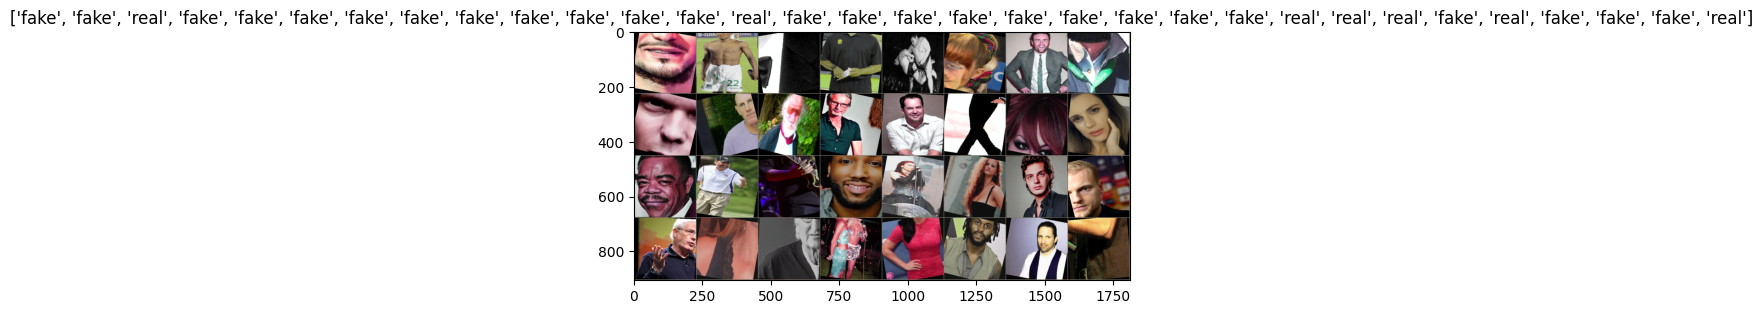

In [85]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array(IMAGENET_MEAN)
    std = np.array(IMAGENET_STD)
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(default_dataloader["train"]))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

## Training the Model

This function trains a deep learning model using supervised learning with PyTorch. Key steps:

- Alternates between training (updating weights) and validation (evaluating performance).
- Uses cross-entropy loss and optimizes with gradient descent.
- Tracks the best validation accuracy, saving model parameters for later use.
- Implements a learning rate scheduler for better convergence.

After training, the model is restored to its best-performing state.

In [86]:
def train_model(model, dataloaders, criterion, optimizer, scheduler, num_epochs=25, verbose=True):
    since = time.time()

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, "best_model_params.pt")

        torch.save(model.state_dict(), best_model_params_path)
        best_f1 = 0.0

        # Store loss, accuracy and f1 values
        history = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": [], 
                  "train_f1": [], "val_f1": []}

        for epoch in range(num_epochs):
            if verbose:
                print(f"Epoch {epoch}/{num_epochs - 1}")
                print("-" * 10)

            # Each epoch has a training and validation phase
            for phase in ["train", "val"]:
                if phase == "train":
                    model.train()  # Set model to training mode
                else:
                    model.eval()  # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0
                all_preds = []
                all_labels = []
                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == "train"):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == "train":
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)

                    # Collect predictions and labels for F1 score
                    all_preds.extend(preds.tolist())
                    all_labels.extend(labels.tolist())

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                if phase == "train" and scheduler is not None:
                    if type(scheduler) is lr_scheduler.ReduceLROnPlateau:
                        scheduler.step(epoch_loss)
                    else:
                        scheduler.step()

                # Convert lists to numpy arrays for sklearn
                all_preds = np.array(all_preds)
                all_labels = np.array(all_labels)

                # Calculate F1 score (using weighted average due to class imbalance)
                epoch_f1 = f1_score(all_labels, all_preds, average='weighted')

                # Store metrics in history
                history[f"{phase}_loss"].append(epoch_loss)
                history[f"{phase}_acc"].append(epoch_acc.item())
                history[f"{phase}_f1"].append(epoch_f1)

                if verbose:
                    print(f"{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} F1: {epoch_f1:.4f}")

                # deep copy the model (using F1 score as the criterion for best model)
                if phase == "val" and epoch_f1 > best_f1:
                    best_f1 = epoch_f1
                    torch.save(model.state_dict(), best_model_params_path)

            if verbose:
                print()

        time_elapsed = time.time() - since
        print(
            f"Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s"
        )
        if verbose:
            print(f"Best val F1: {best_f1:4f}")

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path, weights_only=True))
    return model, history

## Evaluating Model Predictions

This function visualizes the model’s predictions on validation data:

- The model switches to evaluation mode to disable weight updates.
- Images and predicted labels are displayed alongside ground truth data.
- Helps assess model performance qualitatively by identifying correct and incorrect classifications.

This provides an intuitive check on how well the model generalizes to unseen data.

In [87]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(default_dataloader["val"]):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images // 2, 2, images_so_far)
                ax.axis("off")
                ax.set_title(f"predicted: {class_names[preds[j]]}")
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

## Defining and Optimizing the Model

In this step, we initialize a ResNet-18 model pre-trained on ImageNet (IMAGENET1K_V1) and adapt it for our binary classification task (real vs. fake images). The final fully connected (fc) layer is replaced with a new linear layer that outputs two classes.

We define:
- Loss Function: CrossEntropyLoss, commonly used for classification tasks.
- Optimizer: Stochastic Gradient Descent (SGD) with momentum (0.9) to improve convergence.
- Learning Rate Scheduler: The learning rate decays by a factor of 0.1 every 7 epochs to enhance model stability during training.

In [88]:
model_base = models.resnet18()
num_ftrs = model_base.fc.in_features

# Here the size of each output sample is set to 2.
model_base.fc = nn.Linear(num_ftrs, 2)

model_base = model_base.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_base = optim.SGD(model_base.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_base, step_size=7, gamma=0.1)

In [ ]:
model_base, epoch_results_base = train_model(
    model_base, dataloaders["no_augmentation"]["resnet"], criterion, optimizer_base, exp_lr_scheduler, num_epochs=15
)

Epoch 0/9
----------
train Loss: 0.6130 Acc: 0.6539 F1: 0.6486
val Loss: 0.7957 Acc: 0.5338 F1: 0.5434

Epoch 1/9
----------
train Loss: 0.5836 Acc: 0.6820 F1: 0.6813
val Loss: 0.5988 Acc: 0.6895 F1: 0.6708

Epoch 2/9
----------
train Loss: 0.5648 Acc: 0.6964 F1: 0.6964
val Loss: 0.5694 Acc: 0.6772 F1: 0.6838

Epoch 3/9
----------
train Loss: 0.5517 Acc: 0.7106 F1: 0.7110
val Loss: 0.6224 Acc: 0.6239 F1: 0.6425

Epoch 4/9
----------
train Loss: 0.5376 Acc: 0.7198 F1: 0.7206
val Loss: 0.6108 Acc: 0.6367 F1: 0.6550

Epoch 5/9
----------
train Loss: 0.5289 Acc: 0.7250 F1: 0.7258
val Loss: 0.5968 Acc: 0.6441 F1: 0.6619

Epoch 6/9
----------
train Loss: 0.5244 Acc: 0.7292 F1: 0.7302
val Loss: 0.6116 Acc: 0.6303 F1: 0.6490

Epoch 7/9
----------
train Loss: 0.4891 Acc: 0.7523 F1: 0.7533
val Loss: 0.5993 Acc: 0.6473 F1: 0.6652

Epoch 8/9
----------
train Loss: 0.4851 Acc: 0.7561 F1: 0.7570
val Loss: 0.5814 Acc: 0.6517 F1: 0.6693

Epoch 9/9
----------
train Loss: 0.4844 Acc: 0.7561 F1: 0.7570
v

## Training the Model

Now, we train our fine-tuned ResNet-18 model using the previously defined optimizer, loss function, and learning rate scheduler. The model will adjust its weights based on our dataset.

Note: In the original tutorial, the model is trained for 25 epochs, but since we are using more images than the tutorial and training on a CPU, I set it to just 1 epoch to keep runtime around 12 minutes.

## Feature Extraction with ResNet-18

Instead of fine-tuning all ResNet-18 layers, we freeze the pre-trained weights (requires_grad = False) and only train the final fully connected layer for binary classification. This approach, known as feature extraction, is useful when we have a smaller dataset and want to leverage pre-trained features.

- Only the final layer is optimized, making training more efficient.
- We still use SGD with momentum and a learning rate scheduler to optimize training.

This method ensures we benefit from ResNet’s powerful pre-trained features while reducing the computational cost of training. 

In [93]:
model_conv = torchvision.models.resnet18(weights="IMAGENET1K_V1")
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [ ]:
model_conv, epoch_results_conv = train_model(
    model_conv, dataloaders["no_augmentation"]["resnet"], criterion, optimizer_conv, exp_lr_scheduler, num_epochs=15
)

Epoch 0/9
----------
train Loss: 0.5490 Acc: 0.7185 F1: 0.7165
val Loss: 0.5423 Acc: 0.7282 F1: 0.7099

Epoch 1/9
----------
train Loss: 0.5307 Acc: 0.7335 F1: 0.7321
val Loss: 0.6741 Acc: 0.6459 F1: 0.6638

Epoch 2/9
----------
train Loss: 0.5273 Acc: 0.7346 F1: 0.7333
val Loss: 0.6267 Acc: 0.6702 F1: 0.6850

Epoch 3/9
----------
train Loss: 0.5264 Acc: 0.7345 F1: 0.7332
val Loss: 0.6414 Acc: 0.6641 F1: 0.6806

Epoch 4/9
----------
train Loss: 0.5262 Acc: 0.7382 F1: 0.7370
val Loss: 0.6189 Acc: 0.6790 F1: 0.6930

Epoch 5/9
----------
train Loss: 0.5264 Acc: 0.7366 F1: 0.7353
val Loss: 0.7192 Acc: 0.6349 F1: 0.6529

Epoch 6/9
----------
train Loss: 0.5251 Acc: 0.7369 F1: 0.7358
val Loss: 0.6352 Acc: 0.6682 F1: 0.6839

Epoch 7/9
----------
train Loss: 0.5066 Acc: 0.7470 F1: 0.7458
val Loss: 0.6744 Acc: 0.6483 F1: 0.6661

Epoch 8/9
----------
train Loss: 0.5063 Acc: 0.7460 F1: 0.7448
val Loss: 0.6204 Acc: 0.6717 F1: 0.6874

Epoch 9/9
----------
train Loss: 0.5037 Acc: 0.7457 F1: 0.7445
v

In [ ]:
model_resnet_no_augm_ft = models.resnet18(weights="IMAGENET1K_V1")
num_ftrs = model_resnet_no_augm_ft.fc.in_features

# Here the size of each output sample is set to 2.
model_resnet_no_augm_ft.fc = nn.Linear(num_ftrs, 2)

model_resnet_no_augm_ft = model_resnet_no_augm_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_resnet_no_augm_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [ ]:
model_resnet_no_augm_ft, epoch_results_ft = train_model(
    model_resnet_no_augm_ft, dataloaders["no_augmentation"]["resnet"], criterion, optimizer_ft, exp_lr_scheduler, num_epochs=15
)

Epoch 0/9
----------
train Loss: 0.4370 Acc: 0.7849 F1: 0.7849
val Loss: 0.4333 Acc: 0.7790 F1: 0.7887

Epoch 1/9
----------
train Loss: 0.3643 Acc: 0.8289 F1: 0.8293
val Loss: 0.3846 Acc: 0.8120 F1: 0.8207

Epoch 2/9
----------
train Loss: 0.3270 Acc: 0.8510 F1: 0.8515
val Loss: 0.3382 Acc: 0.8300 F1: 0.8370

Epoch 3/9
----------
train Loss: 0.3037 Acc: 0.8623 F1: 0.8626
val Loss: 0.3444 Acc: 0.8324 F1: 0.8397

Epoch 4/9
----------
train Loss: 0.2926 Acc: 0.8697 F1: 0.8701
val Loss: 0.3434 Acc: 0.8420 F1: 0.8480

Epoch 5/9
----------
train Loss: 0.2785 Acc: 0.8745 F1: 0.8749
val Loss: 0.3473 Acc: 0.8434 F1: 0.8489

Epoch 6/9
----------
train Loss: 0.2664 Acc: 0.8840 F1: 0.8843
val Loss: 0.3987 Acc: 0.8077 F1: 0.8172

Epoch 7/9
----------
train Loss: 0.2374 Acc: 0.8955 F1: 0.8958
val Loss: 0.2680 Acc: 0.8749 F1: 0.8791

Epoch 8/9
----------
train Loss: 0.2283 Acc: 0.9007 F1: 0.9009
val Loss: 0.2647 Acc: 0.8754 F1: 0.8797

Epoch 9/9
----------
train Loss: 0.2260 Acc: 0.9004 F1: 0.9007
v

## Visualizing Model Predictions

This function allows us to visualize the model’s prediction for a given image. It follows these steps:

- Loads the image and applies the same transformations used during validation.
- Converts the image into a format suitable for the model (unsqueeze(0) to add batch dimension).
- Disables gradient computation (torch.no_grad()) for efficient inference.
- Predicts the class and displays the image with its predicted label.

This function helps us qualitatively evaluate the model’s performance by seeing its predictions on real examples.

In [96]:
def visualize_model_predictions(model, img_path):
    was_training = model.training
    model.eval()

    img = Image.open(img_path)
    img = resnet_basic_transform(img)
    img = img.unsqueeze(0)
    img = img.to(device)

    with torch.no_grad():
        outputs = model(img)
        _, preds = torch.max(outputs, 1)

        ax = plt.subplot(2, 2, 1)
        ax.axis("off")
        ax.set_title(f"Predicted: {class_names[preds[0]]}")
        imshow(img.cpu().data[0])

        model.train(mode=was_training)

## Running the Visualization on a Sample Image

Here, we test our trained feature extraction model (model_conv) by passing a real image from the validation set. The model's prediction is displayed alongside the image.

Note: Ensure that the input image is not grayscale. The function expects an RGB image (3 channels), and passing a single-channel grayscale image may lead to errors or unexpected behavior.

In [97]:
# visualize_model_predictions(
#     model_conv, img_path="resized_data/val/fake/50745_1941-10-13_2011.jpg"
# )

plt.ioff()
plt.show()

## Plotting Classification Performance

In [98]:
def plot_training_history(history, title_label=""):
    if title_label != "":
        title_label = f": {title_label}"
    epochs = range(len(history["train_loss"]))

    plt.figure(figsize=(12, 5))

    # Loss Plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history["train_loss"], label="Train Loss")
    plt.plot(epochs, history["val_loss"], label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")

    plt.title(f"Training & Validation Loss{title_label}")
    plt.legend()

    # F1 Plot
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history["train_f1"], label="Train F1")
    plt.plot(epochs, history["val_f1"], label="Validation F1")
    plt.xlabel("Epochs")
    plt.ylabel("F1 Score")
    plt.title(f"Training & Validation F1 Score{title_label}")
    plt.legend()


    plt.show()

In [128]:
def test_model(model, test_dataloader, verbose=True):
    """
    Evaluates the model on the test dataset and returns accuracy and F1 score.
    
    Args:
        model (torch.nn.Module): Trained PyTorch model.
    Returns:
        dict: A dictionary containing accuracy and F1 score.
    """
    model.eval()  # Set model to evaluation mode
    running_corrects = 0
    all_preds = []
    all_labels = []
    dataloader = test_dataloader

    with torch.no_grad():  # No need to track gradients during evaluation
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            running_corrects += torch.sum(preds == labels.data)
            all_preds.extend(preds.tolist())
            all_labels.extend(labels.tolist())

    # Compute accuracy
    dataset_size = len(dataloader.dataset)
    accuracy = running_corrects.double() / dataset_size

    # Compute F1-score
    all_labels = np.array(all_labels)
    all_preds = np.array(all_preds)
    f1 = f1_score(np.array(all_labels), np.array(all_preds), average='weighted')

    if verbose:
        print(f"Test Accuracy: {accuracy:.4f}, Test F1 Score: {f1:.4f}")

    return {"acc": accuracy.item(), "f1_score": f1, "labels": all_labels, "preds": all_preds}

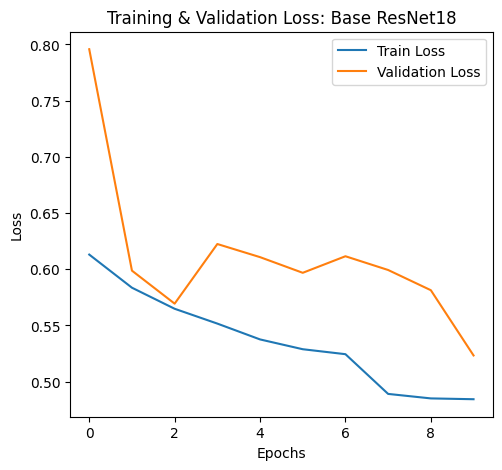

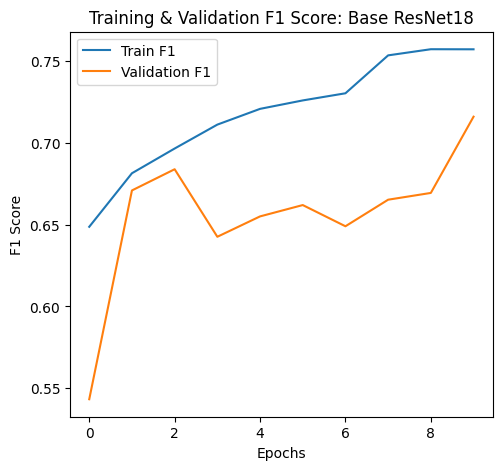

In [100]:
plot_training_history(epoch_results_base, "Base ResNet18")

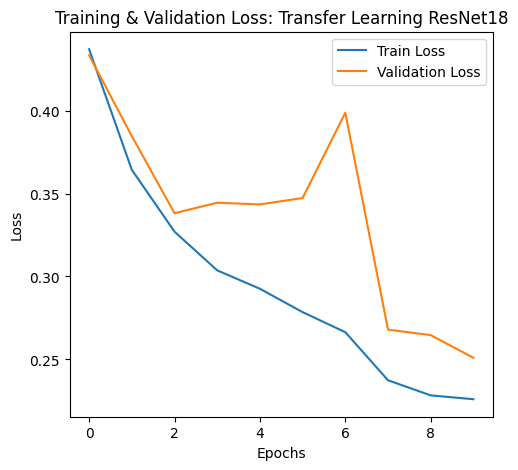

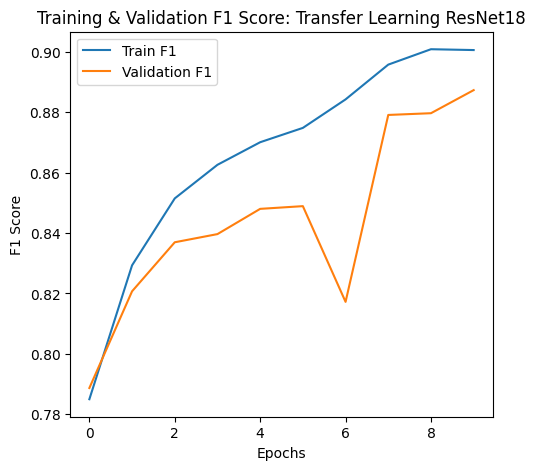

In [101]:
plot_training_history(epoch_results_ft, "Transfer Learning ResNet18")

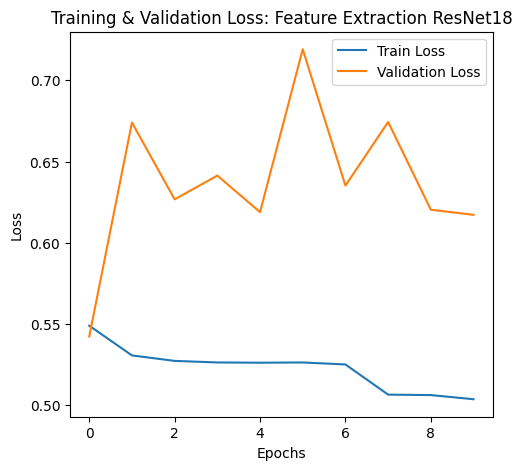

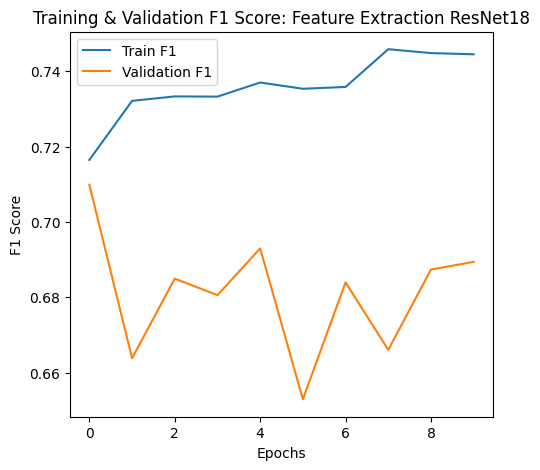

In [102]:
plot_training_history(epoch_results_conv, "Feature Extraction ResNet18")

In [ ]:
model_ft = models.resnet18(weights="IMAGENET1K_V1")
num_ftrs = model_ft.fc.in_features

model_ft_data_augmented = models.resnet18(weights="IMAGENET1K_V1")
num_ftrs = model_ft_data_augmented.fc.in_features

model_ft_data_augmented.fc = nn.Linear(num_ftrs, 2)

model_ft_data_augmented = model_ft_data_augmented.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft_augmented = optim.SGD(model_ft_data_augmented.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft_augmented, step_size=7, gamma=0.1)

model_ft_augmented, epoch_results_ft_augmented = train_model(
    model_ft_data_augmented, dataloaders["augmentation"]["resnet"], criterion, optimizer_ft_augmented, exp_lr_scheduler, num_epochs=15
)

Epoch 0/9
----------
train Loss: 0.4444 Acc: 0.7848 F1: 0.7848
val Loss: 0.3586 Acc: 0.8313 F1: 0.8317

Epoch 1/9
----------
train Loss: 0.3577 Acc: 0.8328 F1: 0.8331
val Loss: 0.3813 Acc: 0.8072 F1: 0.8159

Epoch 2/9
----------
train Loss: 0.3317 Acc: 0.8483 F1: 0.8487
val Loss: 0.3086 Acc: 0.8553 F1: 0.8579

Epoch 3/9
----------
train Loss: 0.3010 Acc: 0.8639 F1: 0.8643
val Loss: 0.2814 Acc: 0.8674 F1: 0.8710

Epoch 4/9
----------
train Loss: 0.2907 Acc: 0.8695 F1: 0.8699
val Loss: 0.3007 Acc: 0.8572 F1: 0.8623

Epoch 5/9
----------
train Loss: 0.2718 Acc: 0.8798 F1: 0.8801
val Loss: 0.2574 Acc: 0.8804 F1: 0.8829

Epoch 6/9
----------
train Loss: 0.2683 Acc: 0.8812 F1: 0.8816
val Loss: 0.2657 Acc: 0.8880 F1: 0.8869

Epoch 7/9
----------
train Loss: 0.2355 Acc: 0.8961 F1: 0.8964
val Loss: 0.2652 Acc: 0.8765 F1: 0.8806

Epoch 8/9
----------
train Loss: 0.2278 Acc: 0.9010 F1: 0.9013
val Loss: 0.2529 Acc: 0.8825 F1: 0.8861

Epoch 9/9
----------
train Loss: 0.2252 Acc: 0.9018 F1: 0.9020
v

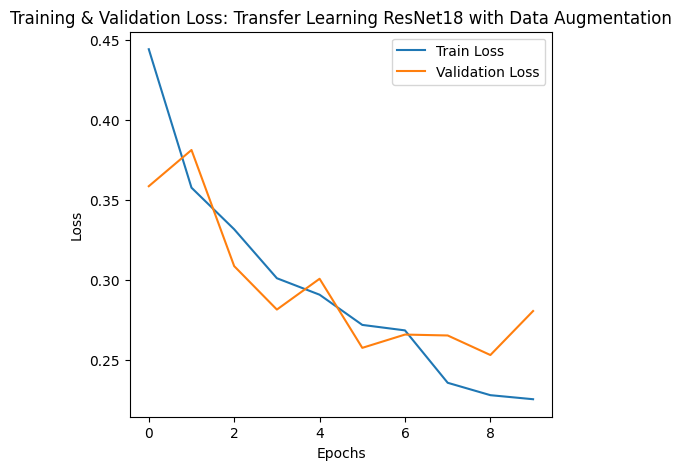

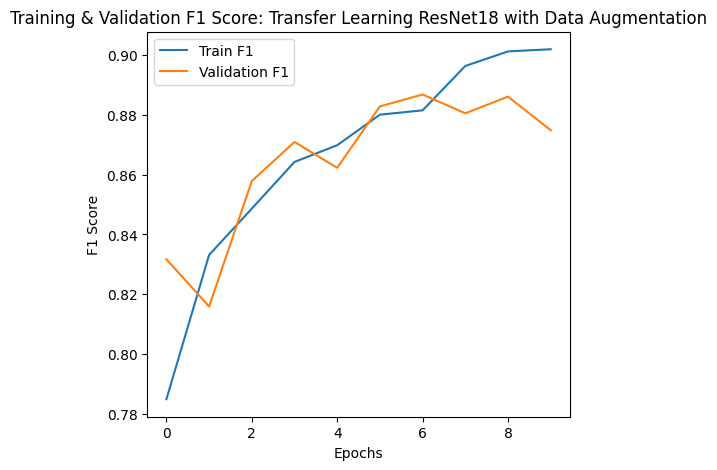

In [107]:
plot_training_history(epoch_results_ft_augmented, "Transfer Learning ResNet18 with Data Augmentation")

#### Improve learning rate decay and attempt to reduce training instability
- Use Adam optimizer
- Use different learning rates
- Use a different learning rate scheduler

In [114]:
def get_plot_location(filename):
    return os.path.join("plots", filename)

def plot_hyperparameter_results(results, model_name):
    """
    Plot the results of hyperparameter tuning
    
    Args:
        results: List of result dictionaries from hyperparameter tuning
    """
    # Sort results by validation F1 score
    sorted_results = sorted(results, key=lambda x: x['val_f1'], reverse=True)

    # 1. Bar plot comparing all configurations by F1 score
    plt.figure(figsize=(14, 8))

    configs = [f"{r['criterion']}\n{r['optimizer']}\n{r['scheduler']}\n{r['lr']}" for r in sorted_results]
    f1_scores = [r['val_f1'] for r in sorted_results]

    bars = plt.bar(range(len(configs)), f1_scores)

    # Color the best configuration differently
    bars[0].set_color('green')

    plt.xticks(range(len(configs)), configs, rotation=90, ha='right')
    plt.xlabel('Hyperparameter Configuration')
    plt.ylabel('Best Validation F1 Score')
    plt.title('Hyperparameter Configurations Ranked by F1 Score')
    plt.tight_layout()
    plt.savefig(get_plot_location(f'hyperparameter_rankings_{model_name}.png'))
    plt.show()

    # 2. Learning curves of top 3 models
    plt.figure(figsize=(16, 12))

    for i, result in enumerate(sorted_results[:min(3, len(sorted_results))]):
        config_name = f"{result['criterion']} + {result['optimizer']} + {result['scheduler']}"

        plt.subplot(3, 2, i*2+1)
        plt.plot(result['history']['train_loss'], label='Train Loss')
        plt.plot(result['history']['val_loss'], label='Validation Loss')
        plt.title(f"Top {i+1}: {config_name} - Loss")
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()

        plt.subplot(3, 2, i*2+2)
        plt.plot(result['history']['train_f1'], label='Train F1')
        plt.plot(result['history']['val_f1'], label='Validation F1')
        plt.title(f"Top {i+1}: {config_name} - F1 Score")
        plt.xlabel('Epoch')
        plt.ylabel('F1 Score')
        plt.legend()

    plt.tight_layout()
    plt.savefig(get_plot_location(f'top_model_learning_curves_{model_name}.png'))
    plt.show()

    # 3. Optimizer comparison
    plt.figure(figsize=(12, 6))
    
    optimizer_groups = {}
    for r in results:
        if r['optimizer'] not in optimizer_groups:
            optimizer_groups[r['optimizer']] = []
        optimizer_groups[r['optimizer']].append(r['val_f1'])
    
    optimizers = list(optimizer_groups.keys())
    avg_f1 = [np.mean(optimizer_groups[opt]) for opt in optimizers]
    max_f1 = [np.max(optimizer_groups[opt]) for opt in optimizers]
    
    x = np.arange(len(optimizers))
    width = 0.35
    
    plt.bar(x - width/2, avg_f1, width, label='Average F1')
    plt.bar(x + width/2, max_f1, width, label='Best F1')
    
    plt.xticks(x, optimizers)
    plt.xlabel('Optimizer')
    plt.ylabel('F1 Score')
    plt.title('Optimizer Performance Comparison')
    plt.legend()
    plt.savefig(get_plot_location(f'optimizer_comparison_{model_name}.png'))
    plt.show()

    # 4. Criterion comparison
    plt.figure(figsize=(12, 6))
    
    criterion_groups = {}
    for r in results:
        if r['criterion'] not in criterion_groups:
            criterion_groups[r['criterion']] = []
        criterion_groups[r['criterion']].append(r['val_f1'])
    
    criterions = list(criterion_groups.keys())
    avg_f1 = [np.mean(criterion_groups[crit]) for crit in criterions]
    max_f1 = [np.max(criterion_groups[crit]) for crit in criterions]
    
    x = np.arange(len(criterions))
    
    plt.bar(x - width/2, avg_f1, width, label='Average F1')
    plt.bar(x + width/2, max_f1, width, label='Best F1')
    
    plt.xticks(x, criterions)
    plt.xlabel('Loss Function')
    plt.ylabel('F1 Score')
    plt.title('Loss Function Performance Comparison')
    plt.legend()
    plt.savefig(get_plot_location(f'criterion_comparison_{model_name}.png'))
    plt.show()
    
    # 5. Scheduler comparison
    plt.figure(figsize=(12, 6))

    scheduler_groups = {}
    for r in results:
        if r['scheduler'] not in scheduler_groups:
            scheduler_groups[r['scheduler']] = []
        scheduler_groups[r['scheduler']].append(r['val_f1'])
    
    schedulers = list(scheduler_groups.keys())
    avg_f1 = [np.mean(scheduler_groups[sched]) for sched in schedulers]
    max_f1 = [np.max(scheduler_groups[sched]) for sched in schedulers]
    
    x = np.arange(len(schedulers))
    
    plt.bar(x - width/2, avg_f1, width, label='Average F1')
    plt.bar(x + width/2, max_f1, width, label='Best F1')
    
    plt.xticks(x, schedulers)
    plt.xlabel('Scheduler')
    plt.ylabel('F1 Score')
    plt.title('Scheduler Performance Comparison')
    plt.legend()
    plt.savefig(get_plot_location(f'scheduler_comparison_{model_name}.png'))
    plt.show()

## Hyperparameter Tuning
We use data augmentation here, as opposed to before on the simple training examples. The performance is much better with data augmentation, so we decided not to tune without it (just a waste of computational resources).

In [ ]:
def hyperparameter_tuning(get_model, num_epochs):
    """Tune hyperparameters and return the best model."""
    criterion_options = {
        "CE": nn.CrossEntropyLoss(),
        "Weighted CE": nn.CrossEntropyLoss(weight=class_weights.to(device)),
    }
    optimizer_options = {
        "sgd":
            lambda params, lr: optim.SGD(params, lr=lr, momentum=0.9),
        "adam":
            lambda params, lr: optim.Adam(params, lr=lr, betas=(0.9, 0.999)),
    }
    scheduler_options = {
        "step_lr":
            lambda opt: lr_scheduler.StepLR(opt, step_size=7, gamma=0.1),
        "plateau_lr":
            lambda opt: lr_scheduler.ReduceLROnPlateau(opt, mode='min', factor=0.1, patience=7),
    }
    learning_rate = [0.001, 0.0001]

    # Generate all combinations
    param_combinations = []
    for criterion_name, criterion in criterion_options.items():
        for opt_name, opt_fn in optimizer_options.items():
            for sched_name, sched_fn in scheduler_options.items():
                for lr in learning_rate:
                    param_combinations.append({
                        'lr': lr,
                        'criterion_name': criterion_name,
                        'criterion': criterion,
                        'opt_name': opt_name,
                        'opt_fn': opt_fn,
                        'sched_name': sched_name,
                        'sched_fn': sched_fn
                    })
    print(f"Total combinations to try: {len(param_combinations)}")

    best_f1 = 0.0
    best_model = None
    best_params = None
    histories = []
    results = []

    for i, params in enumerate(param_combinations):
        # Extract parameters
        criterion_name = params['criterion_name']
        criterion = params['criterion']
        opt_name = params['opt_name']
        opt_fn = params['opt_fn']
        sched_name = params['sched_name']
        sched_fn = params['sched_fn']
        lr = params['lr']

        # Initialize fresh model
        model, model_params = get_model()
        optimizer = opt_fn(model_params, lr)
        scheduler = sched_fn(optimizer) if sched_fn else None

        print(f"\nTrial {i+1}/{len(param_combinations)}")
        print(f"Criterion: {criterion_name}")
        print(f"Optimizer: {opt_name}")
        print(f"Scheduler: {sched_name}")

        # Train and evaluate
        trained_model, history = train_model(
            model,
            dataloaders["augmentation"]["resnet"],
            criterion,
            optimizer,
            scheduler,
            num_epochs=num_epochs,
            verbose=False,
        )

        val_f1 = max(history["val_f1"])  # Best validation F1 from this run
        histories.append(history)

        # Save results for plotting
        results.append({
            'lr': lr,
            'criterion': criterion_name,
            'optimizer': opt_name,
            'scheduler': sched_name,
            'val_f1': val_f1,
            'trial': i+1,
            'history': history
        })

        # Track best model
        if val_f1 > best_f1:
            best_f1 = val_f1
            best_model = trained_model
            best_params = {
                'lr': lr,
                'criterion': criterion_name, 
                'optimizer': opt_name, 
                'scheduler': sched_name
            }

        print(f"Trial {i+1} Best Val F1: {val_f1:.4f}")

    print("\nBest Hyperparameters:")
    print(f"Criterion: {best_params['criterion']}")
    print(f"Optimizer: {best_params['optimizer']}")
    print(f"Scheduler: {best_params['scheduler']}")
    print(f"Best Learning Rate: {best_params['lr']}")
    print(f"Best Validation F1: {best_f1:.4f}")

    return best_model, best_params, best_f1, results

## Models to tune
- Feature extraction from resnet18 performs much worse so it was excluded from hyperparameter tuning
- The other models we experimented with are too heavy for this kind of automatic tuning

In [ ]:
def get_fully_trainable_resnet():
    model = models.resnet18(weights="IMAGENET1K_V1")
    num_ftrs = model.fc.in_features

    model.fc = nn.Linear(num_ftrs, 2)
    model = model.to(device)
    return model, model.parameters()

_models = {
    "Fully Trainable ResNet18": get_fully_trainable_resnet,
}

plot_results = {}
final_model = None
final_model_val_f1 = 0.0
final_model_params = None
for name, model in _models.items():
    print("\n")
    print(name)
    best_model, best_params, best_f1, tuning_results = hyperparameter_tuning(model, num_epochs=15)
    if best_f1 > final_model_val_f1:
        final_model = best_model
        final_model_val_f1 = best_f1
        final_model_params = best_params
    print(f"Finished {name}")

    plot_results[name] = tuning_results



Fully Trainable ResNet18
Total combinations to try: 16

Trial 1/16
Criterion: CE
Optimizer: sgd
Scheduler: step_lr
Training complete in 0m 57s
Trial 1 Best Val F1: 0.8196

Trial 2/16
Criterion: CE
Optimizer: sgd
Scheduler: step_lr
Training complete in 0m 58s
Trial 2 Best Val F1: 0.7131

Trial 3/16
Criterion: CE
Optimizer: sgd
Scheduler: plateau_lr
Training complete in 0m 57s
Trial 3 Best Val F1: 0.8086

Trial 4/16
Criterion: CE
Optimizer: sgd
Scheduler: plateau_lr
Training complete in 0m 58s
Trial 4 Best Val F1: 0.7354

Trial 5/16
Criterion: CE
Optimizer: adam
Scheduler: step_lr
Training complete in 0m 59s
Trial 5 Best Val F1: 0.8119

Trial 6/16
Criterion: CE
Optimizer: adam
Scheduler: step_lr
Training complete in 0m 59s
Trial 6 Best Val F1: 0.8430

Trial 7/16
Criterion: CE
Optimizer: adam
Scheduler: plateau_lr
Training complete in 0m 58s
Trial 7 Best Val F1: 0.7672

Trial 8/16
Criterion: CE
Optimizer: adam
Scheduler: plateau_lr
Training complete in 0m 58s
Trial 8 Best Val F1: 0.8276

Fully Trainable ResNet18


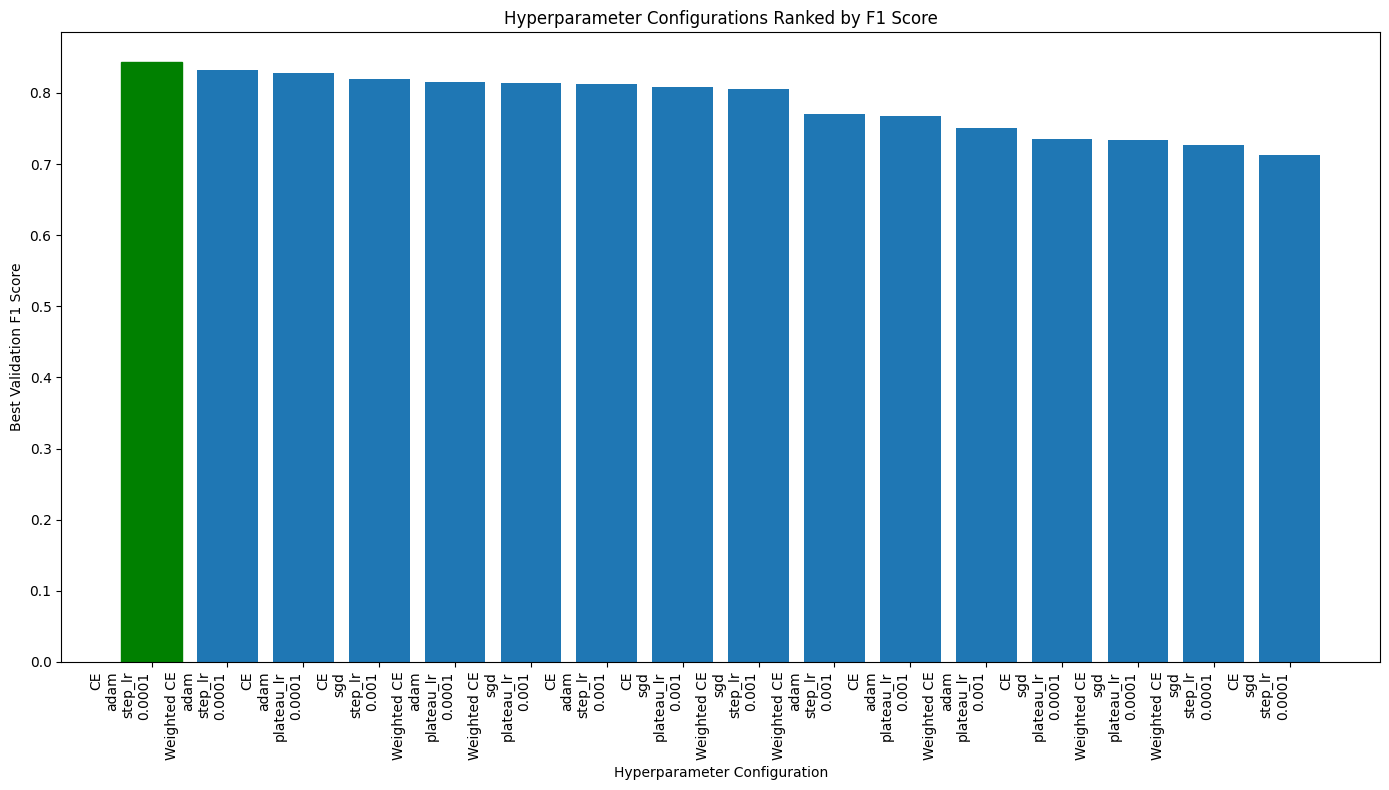

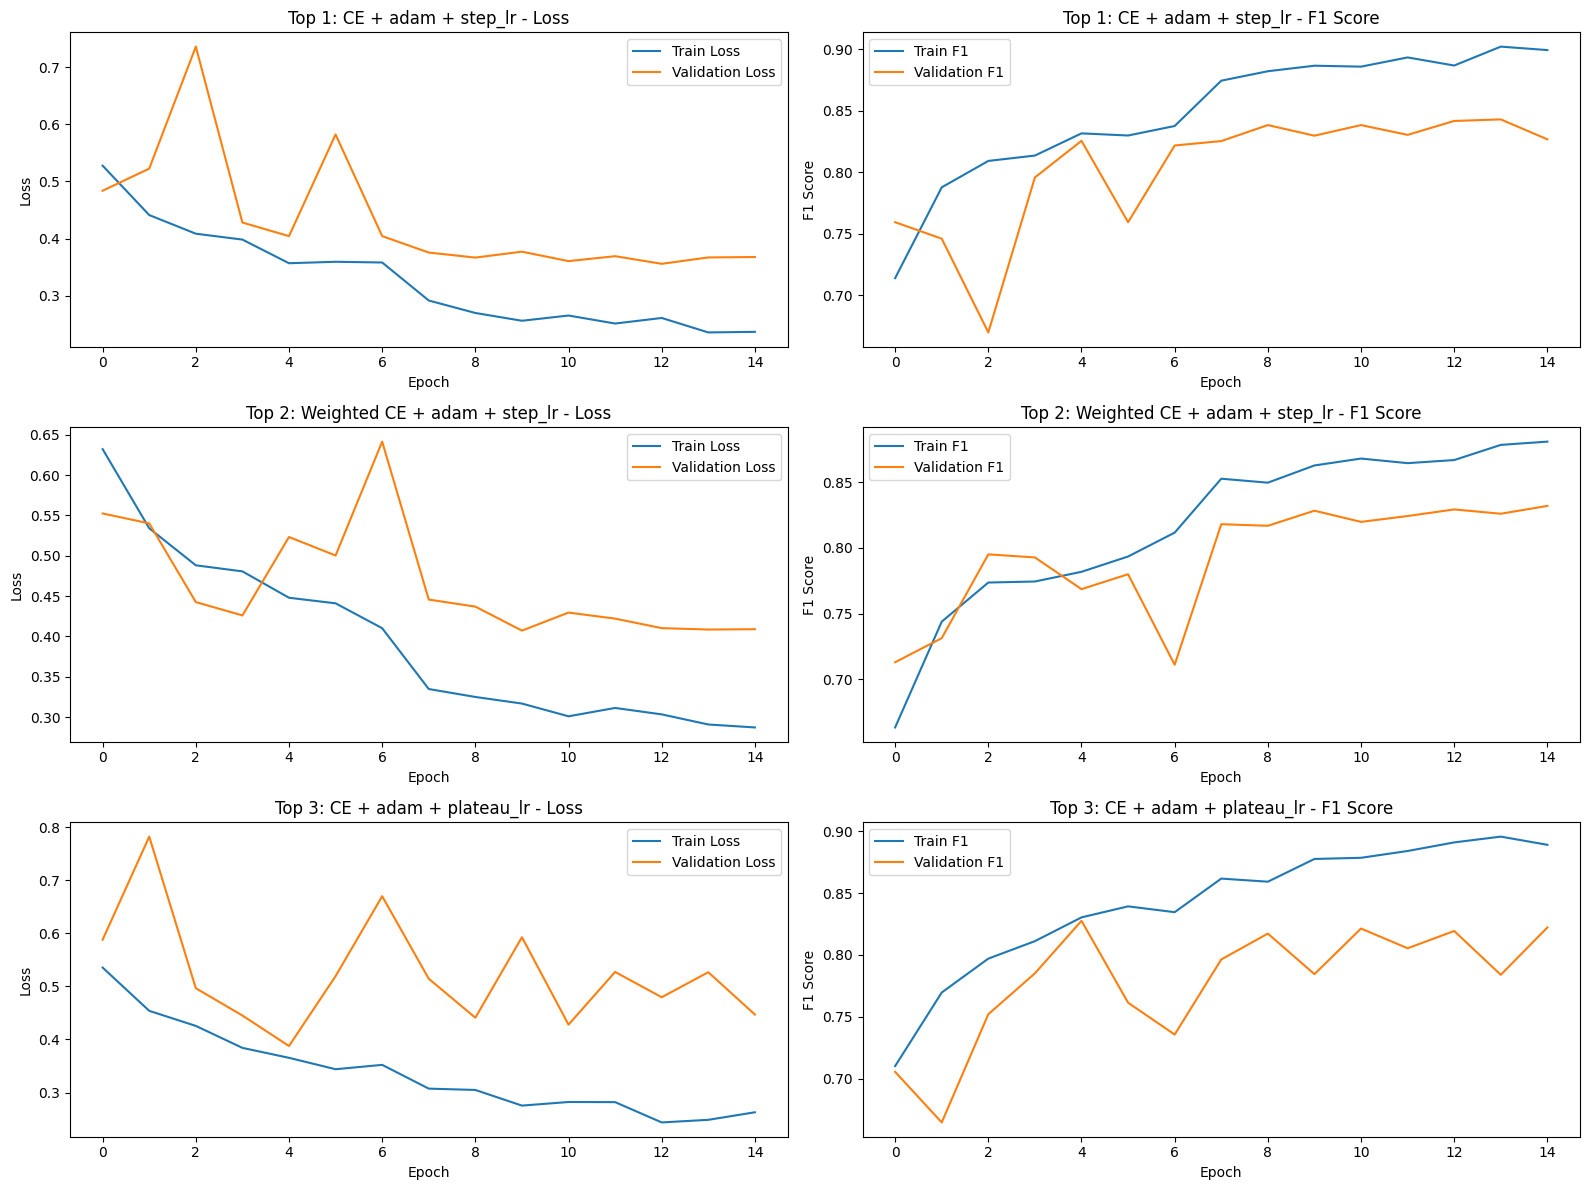

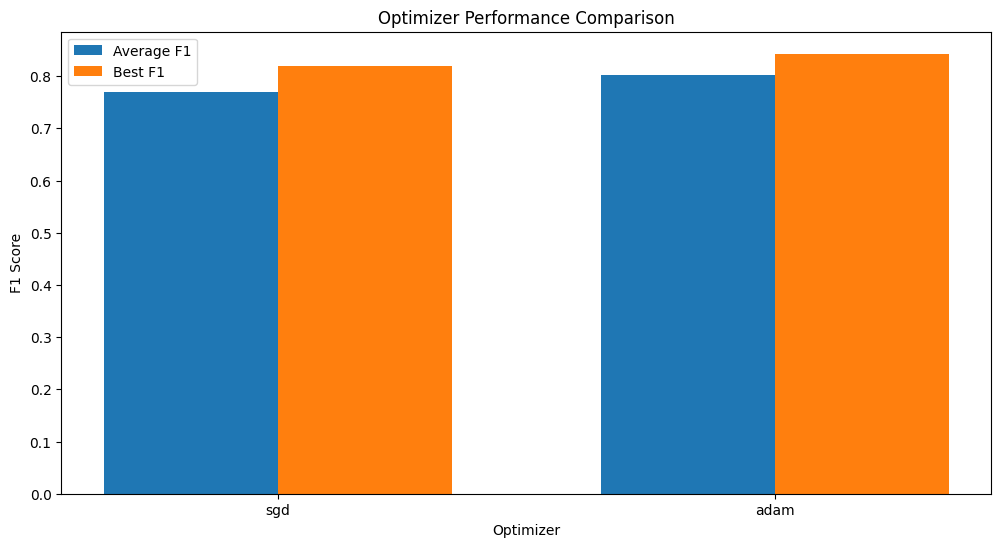

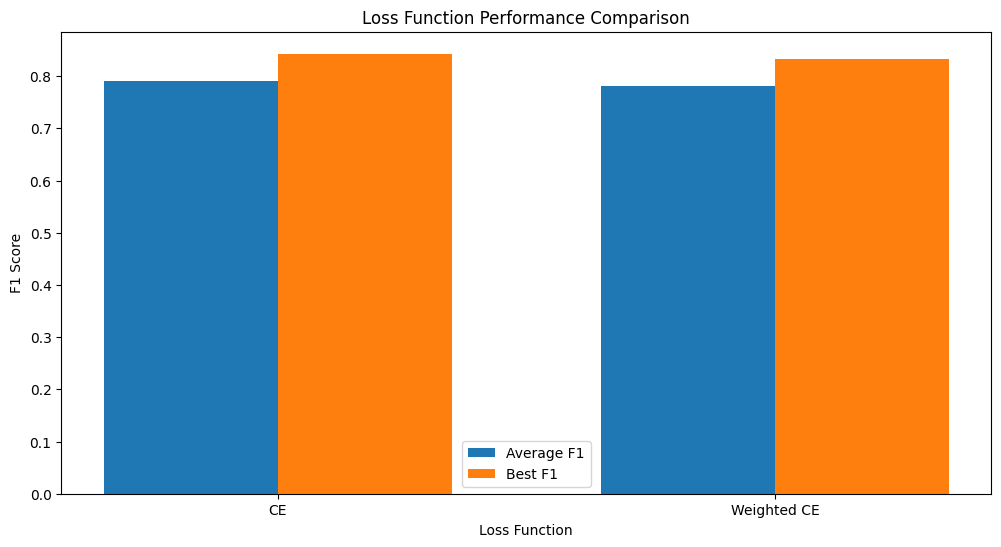

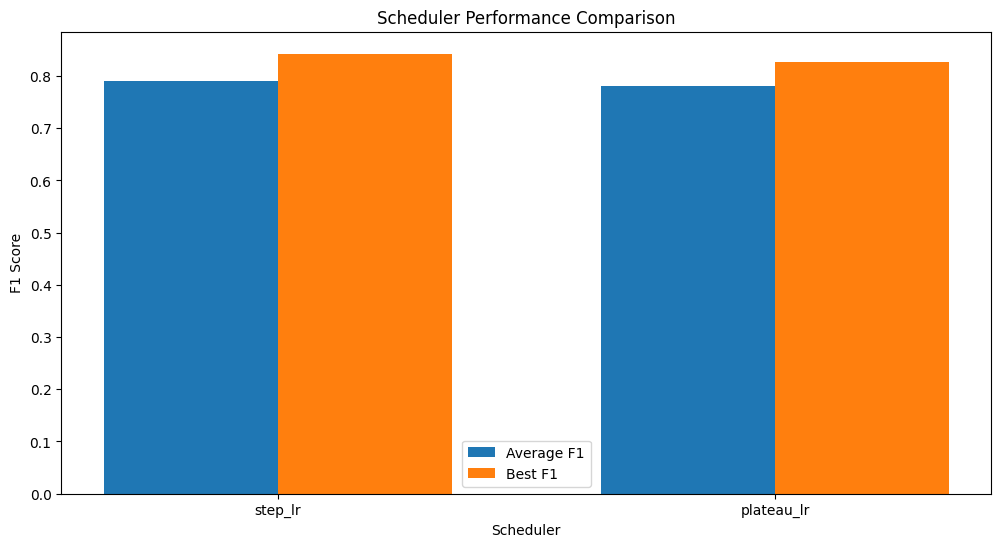

In [76]:
# Plot the results
for model_name, results in plot_results.items():
    print(model_name)
    plot_hyperparameter_results(results, model_name)

In [77]:
test_results = test_model(final_model)
print(f"Best Model: {final_model_params}")
print(f" - Best Validation F1: {final_model_val_f1:.4f}")
print(f" - Test Accuracy: {test_results['acc']:.4f}")
print(f" - Test F1 Score: {test_results['f1_score']:.4f}")

Best Model: {'lr': 0.0001, 'criterion': 'CE', 'optimizer': 'adam', 'scheduler': 'step_lr'}
 - Best Validation F1: 0.8430
 - Test Accuracy: 0.8593
 - Test F1 Score: 0.8546


In [108]:
model_efficient_net_ft = models.efficientnet_v2_s(weights=models.EfficientNet_V2_S_Weights.IMAGENET1K_V1)

# Freeze feature extractor layers (transfer learning)
freeze_layers = False  # Set to True if you only want to train the classifier

if freeze_layers:
    for param in model_efficient_net_ft.features.parameters():
        param.requires_grad = False

# Get the number of input features for the classifier layer
num_ftrs = model_efficient_net_ft.classifier[1].in_features

# Replace the classifier layer with a new one that has 2 output features (for binary classification)
model_efficient_net_ft.classifier[1] = nn.Linear(num_ftrs, 2)

# Move model to the appropriate device (GPU if available, otherwise CPU)
model_efficient_net_ft = model_efficient_net_ft.to(device)

# Define the loss function (CrossEntropyLoss for classification)
criterion = nn.CrossEntropyLoss()

# Define the optimizer
optimizer_efficient_net_ft = optim.Adam(model_efficient_net_ft.parameters(), lr=0.0001)

# Define a learning rate scheduler that decays the learning rate by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [109]:
model_efficient_net_ft, epoch_results_efficient_net = train_model(
    model_efficient_net_ft, dataloaders["augmentation"]["efficient_net"], criterion, optimizer_efficient_net_ft, exp_lr_scheduler, num_epochs=15
)

Epoch 0/14
----------
train Loss: 0.2319 Acc: 0.9013 F1: 0.9014
val Loss: 0.2407 Acc: 0.8923 F1: 0.8964

Epoch 1/14
----------
train Loss: 0.1440 Acc: 0.9435 F1: 0.9435
val Loss: 0.0993 Acc: 0.9600 F1: 0.9601

Epoch 2/14
----------
train Loss: 0.1182 Acc: 0.9537 F1: 0.9538
val Loss: 0.0879 Acc: 0.9642 F1: 0.9645

Epoch 3/14
----------
train Loss: 0.1028 Acc: 0.9597 F1: 0.9597
val Loss: 0.0758 Acc: 0.9707 F1: 0.9709

Epoch 4/14
----------
train Loss: 0.0938 Acc: 0.9636 F1: 0.9636
val Loss: 0.1106 Acc: 0.9596 F1: 0.9599

Epoch 5/14
----------
train Loss: 0.0871 Acc: 0.9667 F1: 0.9667
val Loss: 0.0684 Acc: 0.9729 F1: 0.9731

Epoch 6/14
----------
train Loss: 0.0829 Acc: 0.9682 F1: 0.9682
val Loss: 0.0594 Acc: 0.9784 F1: 0.9785

Epoch 7/14
----------
train Loss: 0.0798 Acc: 0.9693 F1: 0.9693
val Loss: 0.0743 Acc: 0.9718 F1: 0.9721

Epoch 8/14
----------
train Loss: 0.0729 Acc: 0.9719 F1: 0.9720
val Loss: 0.0869 Acc: 0.9683 F1: 0.9687

Epoch 9/14
----------
train Loss: 0.0714 Acc: 0.9729 F1

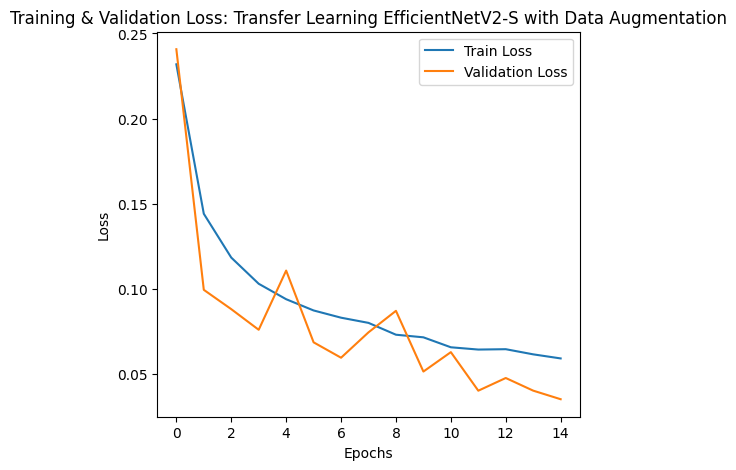

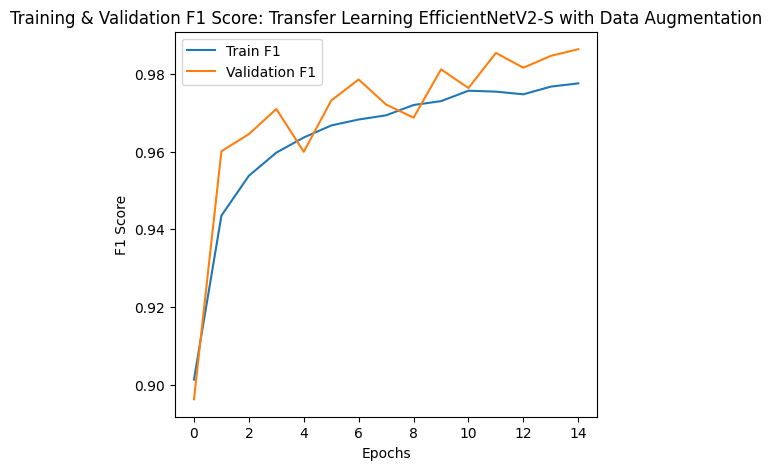

In [110]:
plot_training_history(epoch_results_efficient_net, "Transfer Learning EfficientNetV2-S with Data Augmentation")

In [111]:
model_vit_ft = models.vit_b_16(weights=models.ViT_B_16_Weights.IMAGENET1K_V1)

# Freeze feature extractor layers (transfer learning)
freeze_layers = False  # Set to True if you only want to train the classifier

if freeze_layers:
    for param in model_vit_ft.parameters():
        param.requires_grad = False

# Get the number of input features for the classifier layer
num_ftrs = model_vit_ft.heads.head.in_features

# Replace the classifier layer with a new one that has 2 output features (for binary classification)
model_vit_ft.heads.head = nn.Linear(num_ftrs, 2)

# Move model to the appropriate device (GPU if available, otherwise CPU)
model_vit_ft = model_vit_ft.to(device)

# Define the loss function (CrossEntropyLoss for classification)
criterion = nn.CrossEntropyLoss()

# Define the optimizer
optimizer_ft = optim.Adam(model_vit_ft.parameters(), lr=0.0001)

# Define a learning rate scheduler that decays the learning rate by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [ ]:
model_vit_ft, epoch_results_vit_ft = train_model(
    model_vit_ft, dataloaders["augmentation"]["vit"], criterion, optimizer_ft, exp_lr_scheduler, num_epochs=15
)

Epoch 0/14
----------
train Loss: 0.4062 Acc: 0.8035 F1: 0.8043
val Loss: 0.4895 Acc: 0.7238 F1: 0.7378

Epoch 1/14
----------
train Loss: 0.3330 Acc: 0.8482 F1: 0.8489
val Loss: 0.5170 Acc: 0.7088 F1: 0.7226

Epoch 2/14
----------
train Loss: 0.3071 Acc: 0.8624 F1: 0.8629
val Loss: 0.4116 Acc: 0.7964 F1: 0.8059

Epoch 3/14
----------
train Loss: 0.2934 Acc: 0.8667 F1: 0.8672
val Loss: 0.4045 Acc: 0.8007 F1: 0.8097

Epoch 4/14
----------
train Loss: 0.2794 Acc: 0.8743 F1: 0.8748
val Loss: 0.4245 Acc: 0.7762 F1: 0.7874

Epoch 5/14
----------
train Loss: 0.2722 Acc: 0.8786 F1: 0.8790
val Loss: 0.6307 Acc: 0.6994 F1: 0.7124

Epoch 6/14
----------
train Loss: 0.2592 Acc: 0.8840 F1: 0.8844
val Loss: 0.4074 Acc: 0.7940 F1: 0.8039

Epoch 7/14
----------
train Loss: 0.1879 Acc: 0.9196 F1: 0.9198
val Loss: 0.3107 Acc: 0.8487 F1: 0.8553

Epoch 8/14
----------
train Loss: 0.1674 Acc: 0.9287 F1: 0.9289
val Loss: 0.3226 Acc: 0.8466 F1: 0.8536

Epoch 9/14
----------
train Loss: 0.1577 Acc: 0.9323 F1

In [ ]:
model_vit_ft_v2 = models.vit_b_16(weights=models.ViT_B_16_Weights.IMAGENET1K_V1)

# Freeze feature extractor layers (transfer learning)
freeze_layers = False  # Set to True if you only want to train the classifier

if freeze_layers:
    for param in model_vit_ft_v2.parameters():
        param.requires_grad = False

# Get the number of input features for the classifier layer
num_ftrs = model_vit_ft_v2.heads.head.in_features

# Replace the classifier layer with a new one that has 2 output features (for binary classification)
model_vit_ft_v2.heads.head = nn.Linear(num_ftrs, 2)

# Move model to the appropriate device (GPU if available, otherwise CPU)
model_vit_ft_v2 = model_vit_ft_v2.to(device)

# Define the loss function (CrossEntropyLoss for classification)
criterion = nn.CrossEntropyLoss()

# Define the optimizer
optimizer_ft = optim.Adam(model_vit_ft_v2.parameters(), lr=0.0001)

# Define a learning rate scheduler that decays the learning rate by a factor of 0.1 every 7 epochs
plateau_lr_scheduler = lr_scheduler.ReduceLROnPlateau(optimizer_ft, mode='min', factor=0.1, patience=7)

In [ ]:
model_vit_ft_v2, epoch_results_vit_ft = train_model(
    model_vit_ft_v2, dataloaders["augmentation"]["vit"], criterion, optimizer_ft, plateau_lr_scheduler, num_epochs=25
)

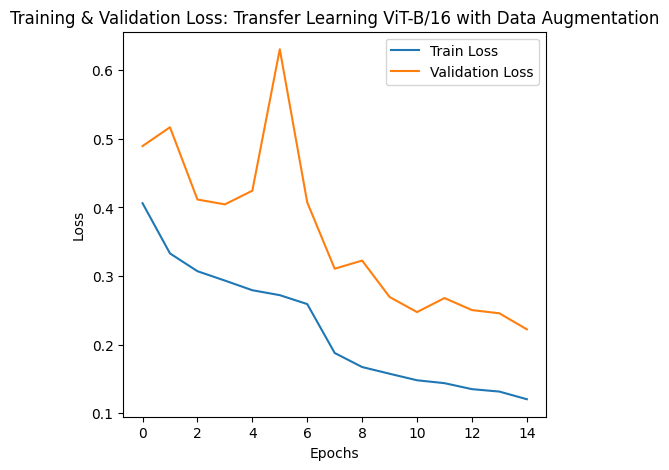

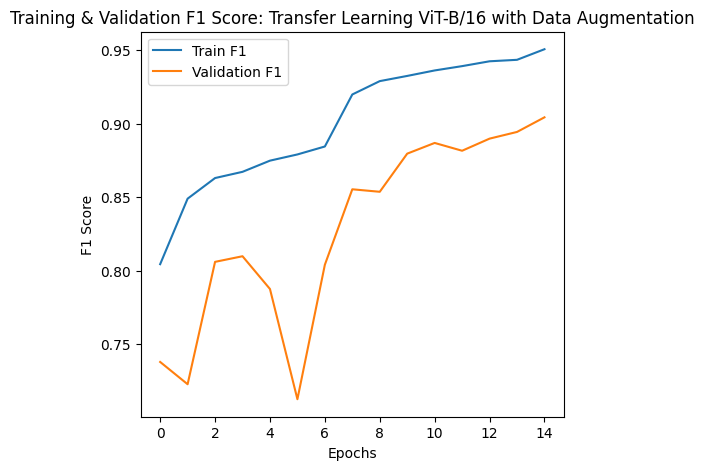

In [113]:
plot_training_history(epoch_results_vit_ft, "Transfer Learning ViT-B/16 with Data Augmentation")

In [137]:
results = test_model(model_efficient_net_ft, dataloaders["augmentation"]["efficient_net"]["test"])

Test Accuracy: 0.9863, Test F1 Score: 0.9863


In [131]:
test_labels = results["labels"]
test_preds = results["preds"]
conf_matrix = confusion_matrix(test_labels, test_preds)

print(classification_report(test_labels, test_preds, target_names=class_names))
print(conf_matrix)

              precision    recall  f1-score   support

        fake       0.99      0.99      0.99     11596
        real       0.97      0.98      0.98      4500

    accuracy                           0.99     16096
   macro avg       0.98      0.98      0.98     16096
weighted avg       0.99      0.99      0.99     16096

[[11483   113]
 [  107  4393]]


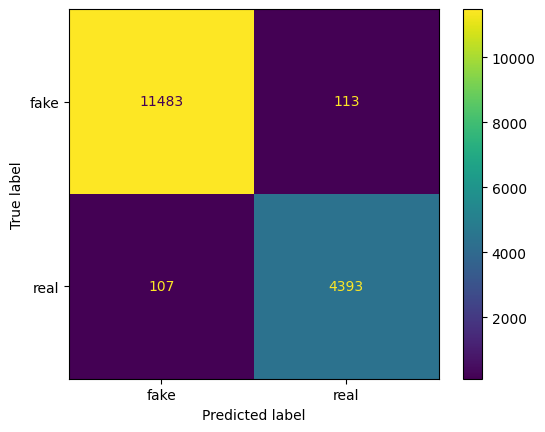

In [136]:
ConfusionMatrixDisplay(conf_matrix, display_labels=class_names).plot()
plt.show()